# Interleaved Transformers

Interleaving transformer(s) is an additional feature designed to help users in debugging a pipeline or spotting bottlenecks.

In short, it is the possibility to inject a transformer or a list of transformer between each other trasformers belonging to a specific `TransformerPipeline` object.

In [1]:
import sys

from pyspark.sql import functions as F
from pyspark.sql.types import *

import yaml

from nebula.spark_transformers import *
from nebula.base import Transformer
from nebula.pipelines.pipelines import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline
from nebula.storage import nebula_storage as ns

py_version = ".".join(map(str, (sys.version_info[0:2])))
print("python version:", py_version)

python version: 3.9


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 14:09:28 WARN [Thread-3] Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
schema = [
    StructField("c1", FloatType(), True),
    StructField("c2", StringType(), True),
    StructField("c3", StringType(), True),
]

data = [
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [1.1234, "a", "  b"],
    [2.1234, "  a  ", "  b  "],
    [3.1234, "", ""],
    [4.1234, "   ", "   "],
    [5.1234, None, None],
    [6.1234, " ", None],
    [7.1234, "", None],
    [8.1234, "a", None],
    [9.1234, "a", ""],
    [10.1234, "   ", "b"],
    [11.1234, "a", None],
    [12.1234, None, "b"],
    [13.1234, None, "b"],
    [14.1234, None, None],
]

df_input = spark.createDataFrame(data, schema=StructType(schema)).cache()
df_input.show()

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
| 0.1234|    a|    b|
| 0.1234|    a|    b|
| 0.1234|    a|    b|
| 1.1234|    a|    b|
| 2.1234|  a  |  b  |
| 3.1234|     |     |
| 4.1234|     |     |
| 5.1234| null| null|
| 6.1234|     | null|
| 7.1234|     | null|
| 8.1234|    a| null|
| 9.1234|    a|     |
|10.1234|     |    b|
|11.1234|    a| null|
|12.1234| null|    b|
|13.1234| null|    b|
|14.1234| null| null|
+-------+-----+-----+



### Basic example

In the following pipeline, `LogDataSkew` is used as interleaved transformer by setting the keyword argument `interleaved`.

`LogDataSkew` is a very powerful transformer used to spot when where data skew becomes excessive, leaving the majority of spark partitions empty, while a few are overloaded with data, significantly degrading the overall perfomances.

By setting it as interleaved object, users gain the capability to spot which transformer is responsible for the data skew.

In [4]:
first_stage_pipe = TransformerPipeline(
    [
        EmptyStringToNull(columns=["c2", "c3"]),
        Distinct(),
        CoalescePartitions(num_partitions=5),
        Cache(),
    ], 
    name="flat-pipeline",
    interleaved=LogDataSkew(),  # 'interleaved' can be a transformer or a <list> of transformers
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "flat-pipeline" (7 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - LogDataSkew
 - Distinct
 - LogDataSkew
 - CoalescePartitions -> PARAMS: num_partitions=5
 - LogDataSkew
 - Persist


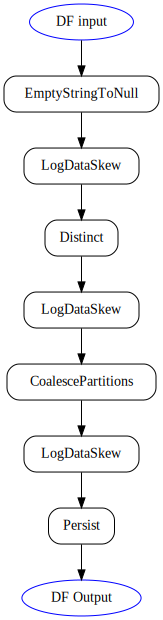

In [5]:
first_stage_pipe.plot_dag()

### Interleaved transformers in nested pipelines

Interleaved transformers are injected **between** other transformers / pipeline, but they are **not injected in the nested pipelines**.

The following pipelines is made of
- `EmptyStringToNull`
- `Distinct`
- nested pipeline `inner-pipeline w/o interleaved`
    - `CoalescePartitions`
    - `Cache`
    
The interleaved transformer set in the outermost pipeline does not affect the nested one.

In [6]:
first_stage_pipe = TransformerPipeline(
    [
        EmptyStringToNull(columns=["c2", "c3"]),
        Distinct(),
        TransformerPipeline([
            CoalescePartitions(num_partitions=5),
            Cache(),
        ],name="inner-pipeline w/o interleaved"),
    ], 
    name="nested-pipeline w/ interleaved",
    interleaved=[LogDataSkew()],  # 'interleaved' can be a transformer or a <list> of transformers
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "nested-pipeline w/ interleaved" (6 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - LogDataSkew
 - Distinct
 - LogDataSkew
*** TransformerPipeline ***: "inner-pipeline w/o interleaved" (2 transformers)
 - CoalescePartitions -> PARAMS: num_partitions=5
 - Persist


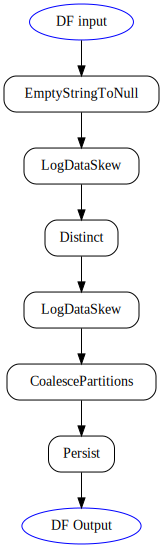

In [7]:
first_stage_pipe.plot_dag()

### Another example of a pipeline made of 2 sub-pipelines

In [8]:
first_stage_pipe = TransformerPipeline(
    [
        TransformerPipeline([
            EmptyStringToNull(columns=["c2", "c3"]),
            Distinct(),
        ], name="pipe-1"),
        TransformerPipeline([
            CoalescePartitions(num_partitions=5),
            Cache(),
        ], name="pipe-2"),
    ], 
    name="nested-pipeline",
    interleaved=LogDataSkew(),
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "nested-pipeline" (5 transformers)
*** TransformerPipeline ***: "pipe-1" (2 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - Distinct
 - LogDataSkew
*** TransformerPipeline ***: "pipe-2" (2 transformers)
 - CoalescePartitions -> PARAMS: num_partitions=5
 - Persist


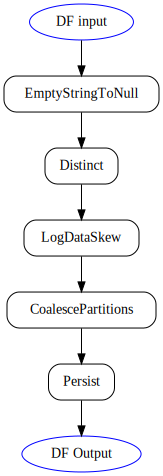

In [9]:
first_stage_pipe.plot_dag()

### Append and prepend the interleaved transformers

So far they have been injected between the other transformers.

However it is also possible add them at the beginning and at the end of the pipeline by setting to `True` the arguments `prepend_interleaved` and `append_interleaved`.

In [10]:
first_stage_pipe = TransformerPipeline(
    [
        EmptyStringToNull(columns=["c2", "c3"]),
        Distinct(),
        CoalescePartitions(num_partitions=5),
        Cache(),
    ], 
    name="flat-pipeline",
    interleaved=[LogDataSkew()],
    prepend_interleaved=True,
    append_interleaved=True,
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "flat-pipeline" (9 transformers)
 - LogDataSkew
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - LogDataSkew
 - Distinct
 - LogDataSkew
 - CoalescePartitions -> PARAMS: num_partitions=5
 - LogDataSkew
 - Persist
 - LogDataSkew


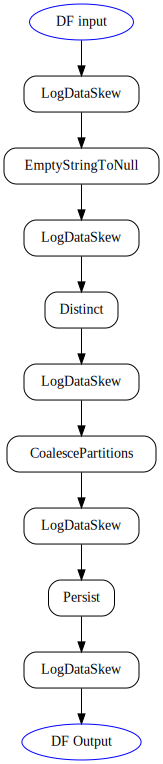

In [11]:
first_stage_pipe.plot_dag()

### General rule: 
**Interleaved (and prepend / append) transformers are properties of the pipeline.<br>
These properties are not inherited by its nested pipelines.**

### Split pipelines

The same concepts apply to the split pipelines. 

If a split is a list of transformers, interleaved ones are interjected, otherwise, if it is a nested pipeline, no.

In [12]:
def my_split_function(df):
    cond = F.col("c1") < 10
    return {
        "low": df.filter(cond),
        "hi": df.filter(~cond),
    }


low_values = [RoundValues(input_columns="c1"), Cast(cast={ "c1": "float" })]
hi_values = TransformerPipeline(
    [EmptyStringToNull(columns="c2"), Cast(cast={ "c1": "float" })], name="no-iterleaved-here"
)

split_pipe = TransformerPipeline(
    {"low": low_values, "hi": hi_values},
    name="split-low-hi-values",
    split_function=my_split_function,
    interleaved=LogDataSkew(),
)

split_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "split-low-hi-values" (5 transformers)
SPLIT <<< hi >>>:
    *** TransformerPipeline ***: "no-iterleaved-here" (2 transformers)
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1"
     - LogDataSkew
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


### Using YAML

In [13]:
yml_data = """
name: "split-low-hi-values"
split_function: my_split_function
interleaved:
    transformer: LogDataSkew
pipeline:
 "low":
   - transformer: RoundValues
     params:
       "input_columns": "c1"
       "precision": 1
   - transformer: Cast
     params:
       "cast": { "c1": "float" }

 "hi":
     name: "no-iterleaved-here"
     pipeline:
       - transformer: EmptyStringToNull
         params:
           "columns": "c2"
       - transformer: Cast
         params:
           "cast": { "c1": "float" }
"""

pipe_cfg = yaml.safe_load(yml_data)

final_pipe = load_pipeline(
    pipe_cfg,
    extra_functions={"my_split_function": my_split_function}
)

final_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "split-low-hi-values" (5 transformers)
SPLIT <<< hi >>>:
    *** TransformerPipeline ***: "no-iterleaved-here" (2 transformers)
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1", precision=1
     - LogDataSkew
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


In [14]:
final_pipe.run(df_input).show()

2024-05-16 14:09:37,301 | pipelines.py:523 [INFO]: Running *** TransformerPipeline ***: "split-low-hi-values" (5 transformers) 
2024-05-16 14:09:37,474 | pipelines.py:556 [INFO]: Running SPLIT <<< hi >>> 
2024-05-16 14:09:37,475 | pipelines.py:516 [INFO]: Running *** TransformerPipeline ***: "no-iterleaved-here" (2 transformers) 
2024-05-16 14:09:37,475 | pipelines.py:283 [INFO]: Running EmptyStringToNull -> PARAMS: columns="c2" ... 
2024-05-16 14:09:37,749 | pipelines.py:297 [INFO]: Execution time for EmptyStringToNull: 0.3s 
2024-05-16 14:09:37,750 | pipelines.py:283 [INFO]: Running Cast -> PARAMS: cast={'c1': 'float'} ... 
2024-05-16 14:09:37,766 | pipelines.py:297 [INFO]: Execution time for Cast: 0.0s 
2024-05-16 14:09:37,767 | pipelines.py:556 [INFO]: Running SPLIT <<< low >>> 
2024-05-16 14:09:37,767 | pipelines.py:283 [INFO]: Running RoundValues -> PARAMS: input_columns="c1", precision=1 ... 
2024-05-16 14:09:37,778 | pipelines.py:297 [INFO]: Execution time for RoundValues: 0.0s

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
|10.1234|     |    b|
|11.1234|    a| null|
|12.1234| null|    b|
|13.1234| null|    b|
|14.1234| null| null|
|    0.1|    a|    b|
|    0.1|    a|    b|
|    0.1|    a|    b|
|    1.1|    a|    b|
|    2.1|  a  |  b  |
|    3.1|     |     |
|    4.1|     |     |
|    5.1| null| null|
|    6.1|     | null|
|    7.1|     | null|
|    8.1|    a| null|
|    9.1|    a|     |
+-------+-----+-----+

